In [ ]:
pip install distance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import pickle
import distance
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import gensim
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from fuzzywuzzy import fuzz
from scipy.sparse import hstack
from itertools import product
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
 
DATAPATH = "/content/drive/MyDrive"
DATA_FILE = "questions.csv"
DATA_NEW = "TRAIN_NEW.csv"
DATA_UPDATED = "TRAIN_UPDATED.csv"
DATA_ADV = "TRAIN_ADV.csv"
DATA_ADV2 = "TRAIN_ADV2.csv"

In [ ]:
pip install fuzzywuzzy

In [ ]:
data_raw = pd.read_csv(os.path.join(DATAPATH, DATA_FILE))
data_raw.head()


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
print("Shape of data = "+str(data_raw.shape))

Shape of data = (404351, 6)


In [ ]:
data_raw.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
#printing indices of points which contain null values
nullIndices = []
for index, textinfo in data_raw.iterrows():
    if type(textinfo["question1"]) is not str or type(textinfo["question2"]) is not str:
        print(index)
        nullIndices.append(index)


105796
201871
363416


In [ ]:
data_raw.drop(nullIndices, axis = 0, inplace = True)
data_raw.isnull().sum()


id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [ ]:
data_raw['is_duplicate'].value_counts()

0    255042
1    149306
Name: is_duplicate, dtype: int64

In [ ]:
label_name = data_raw['is_duplicate'].map({0:"Not-Duplicate", 1:"Duplicate"})
label_name.value_counts()


Not-Duplicate    255042
Duplicate        149306
Name: is_duplicate, dtype: int64

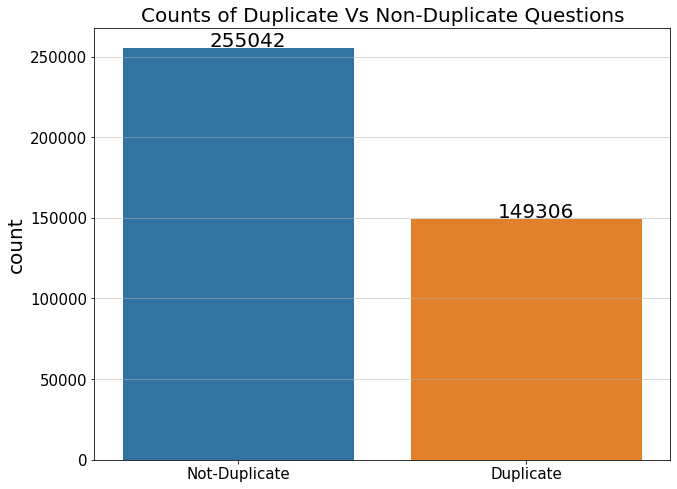

In [ ]:
fig = plt.figure(figsize = (8, 6))
axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Counts of Duplicate Vs Non-Duplicate Questions", fontsize = 20)
axes.set_ylabel("Count", fontsize = 20)
plt.grid(linestyle='-', linewidth=0.5)
axes.tick_params(labelsize = 15)
sns.countplot(list(label_name), ax = axes)
for i in axes.patches:
    axes.text(i.get_x()+0.3, i.get_height()+1000, str(round(i.get_height(), 2)), fontsize=20, color='black')
plt.show()


In [ ]:
data_raw_nonDup = data_raw[data_raw['is_duplicate'] == 0]
data_raw_Dup = data_raw[data_raw['is_duplicate'] == 1]
print("Non Dup Ques Shape = "+str(data_raw_nonDup.shape))
print( "Dup Ques Shape = "+str(data_raw_Dup.shape))


Non Dup Ques Shape = (255042, 6)
Non Dup Ques Shape = (149306, 6)


In [ ]:
totalFrame = [data_raw_nonDup.sample(data_raw_nonDup.shape[0]-105700), data_raw_Dup]
data_new = pd.concat(totalFrame)
data_new.sort_values('id', axis=0, ascending=True, inplace=True)
data_new.reset_index(drop = True, inplace = True)
data_new.head()


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:

data_new['is_duplicate'].value_counts()

0    149342
1    149306
Name: is_duplicate, dtype: int64

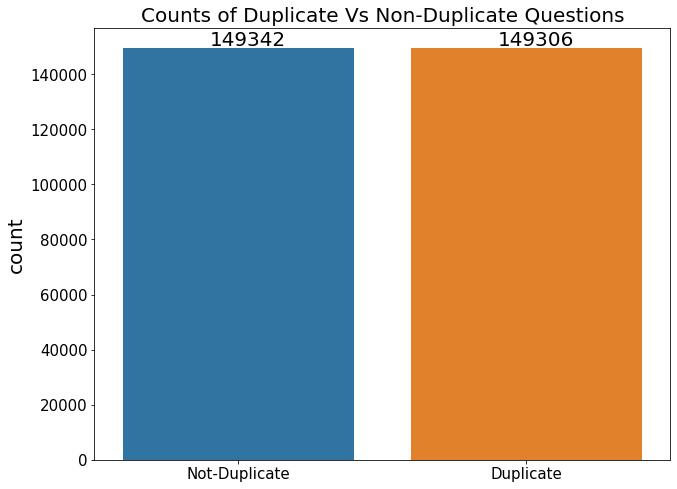

In [ ]:
label_name = data_new['is_duplicate'].map({0:"Not-Duplicate", 1:"Duplicate"})
fig = plt.figure(figsize = (8, 6))
axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Counts of Duplicate Vs Non-Duplicate Questions", fontsize = 20)
axes.set_ylabel("Count", fontsize = 20)
axes.tick_params(labelsize = 15)
sns.countplot(list(label_name), ax = axes)
for i in axes.patches:
    axes.text(i.get_x()+0.3, i.get_height()+1000, str(round(i.get_height(), 2)), fontsize=20, color='black')
plt.show()

In [ ]:
#saving new data frame
data_new.to_csv(os.path.join(DATAPATH, DATA_NEW), index = False)

In [ ]:
data_balanced = pd.read_csv(os.path.join(DATAPATH, DATA_NEW))
data_balanced['is_duplicate'].value_counts()

0    149342
1    149306
Name: is_duplicate, dtype: int64

In [ ]:
print("Shape of data = "+str(data_balanced.shape))

Shape of data = (298648, 6)


In [ ]:
data_balanced.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:

total_ques = pd.Series(data_balanced['qid1'].tolist() + data_balanced['qid2'].tolist()) #here, by addition all of the elements of
#both the arrays will merge into one big array. So, now 'total_ques' contains ids of both 'qid1' and 'qid2' in one big array.
unique_ques = len(np.unique(total_ques))
non_unique_ques = np.sum(total_ques.value_counts()>1) #now, the value_counts() have the values greater than one for all those 
#elements who are occurring more than one. So, this give give us the count of all the number of repeated questions.
print("Total number of unique questions = "+str(unique_ques))
print("Total number of unique questions that appeared more than one time = "+str(non_unique_ques))
print("Question which appeared most number of times = "+str(max(total_ques.value_counts())))

Total number of unique questions = 586826
Total number of unique questions that appeared more than one time = 7637
Question which appeared most number of times = 41


In [ ]:
data_duplicates = data_balanced[['qid1','qid2', 'question1','question2','is_duplicate']].groupby(['qid1', 'qid2']).count()
print("Numbr of duplicate entries = "+str(data_balanced.shape[0] - data_duplicates.shape[0]))

Numbr of duplicate entries = 2


Text(0, 0.5, 'Number of questions')

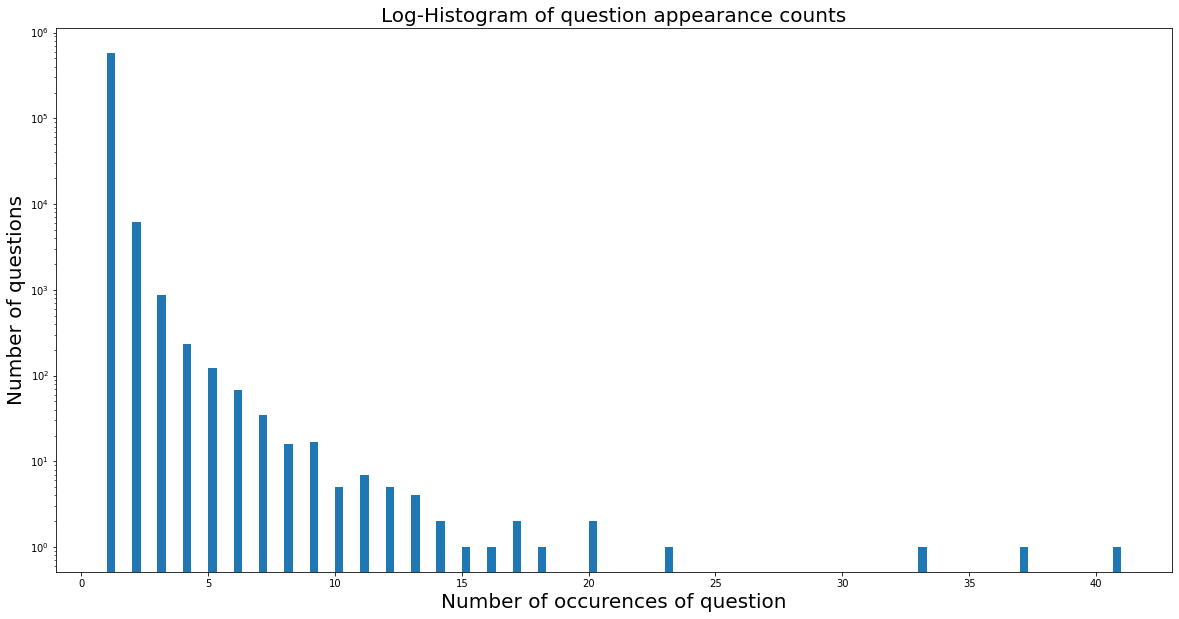

In [ ]:
plt.figure(figsize=(20, 10))

plt.hist(total_ques.value_counts(), bins=120) #here, what we have done is that we have created 120 bins of the occurrences of 
#each of the question. Here, total_ques.value_counts() will give a pandas series which is a sort of dictionary. Here, keys of 
#this series is an id of a question and value is its occurrences. Now, the highest occurrences of a question is 113 and lowest is
#1. Now, we have divided this range of 1 to 113 into 120 equal bins and counted how many values fall in each bin which are 
#reflected on y-axis. Let say the first bin is from 1 to 1.7, so now we have counted how many questions are occurring one time 
#and plotted the same on y-axis and so on

plt.yscale('log')

plt.title('Log-Histogram of question appearance counts', fontsize = 20)

plt.xlabel('Number of occurences of question', fontsize = 20)

plt.ylabel('Number of questions', fontsize = 20)

In [ ]:
data_balanced2 = pd.read_csv(os.path.join(DATAPATH, DATA_NEW))
data_balanced2.shape

(298648, 6)

In [ ]:
data_balanced2['Freq_qid1'] = data_balanced2.groupby('qid1')['qid1'].transform('count')
data_balanced2['Freq_qid2'] = data_balanced2.groupby('qid2')['qid2'].transform('count')

data_balanced2['Q1_len'] = data_balanced2['question1'].apply(lambda x: len(x))
data_balanced2['Q2_len'] = data_balanced2['question2'].apply(lambda x: len(x))

data_balanced2['Q1_n_words'] = data_balanced2['question1'].apply(lambda x: len(x.split(" ")))
data_balanced2['Q2_n_words'] = data_balanced2['question2'].apply(lambda x: len(x.split(" ")))

def Word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)
data_balanced2['Word_Common'] = data_balanced2.apply(Word_Common, axis = 1)

def Word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * (len(w1) + len(w2))
data_balanced2['Word_Total'] = data_balanced2.apply(Word_Total, axis = 1)

data_balanced2['Word_Share'] = data_balanced2['Word_Common']/data_balanced2['Word_Total']

data_balanced2['Freq_q1+Freq_q2'] = data_balanced2['Freq_qid1'] + data_balanced2['Freq_qid2']

data_balanced2['Freq_q1-Freq_q2'] = abs(data_balanced2['Freq_qid1'] - data_balanced2['Freq_qid2'])

data_balanced2.to_csv(os.path.join(DATAPATH, DATA_UPDATED), index = False)

data_balanced2.head()

,id,qid1,qid2,question1,question2,is_duplicate,Freq_qid1,Freq_qid2,Q1_len,Q2_len,Q1_n_words,Q2_n_words,Word_Common,Word_Total,Word_Share,Freq_q1+Freq_q2,Freq_q1-Freq_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


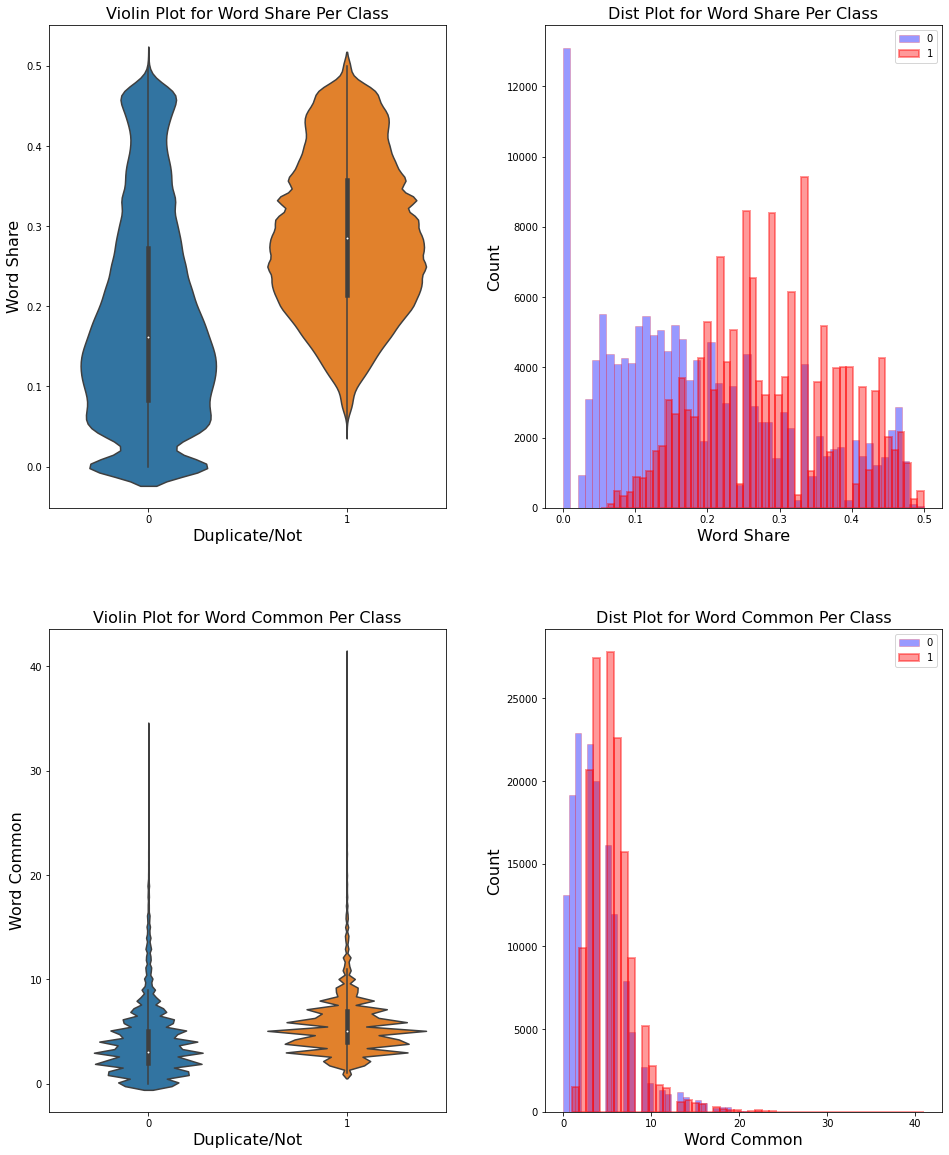

In [ ]:
plt.figure(figsize=(16, 20))

plt.subplot(2,2,1)
sns.violinplot(x = 'is_duplicate', y = 'Word_Share', data = data_balanced2)
plt.title("Violin Plot for Word Share Per Class", fontsize = 16)
plt.xlabel("Duplicate/Not", fontsize = 16)
plt.ylabel("Word Share", fontsize = 16)

plt.subplot(2,2,2)
sns.distplot(data_balanced2[data_balanced2['is_duplicate'] == 0]['Word_Share'], kde = False, color = 'blue', label = '0', hist_kws=dict(edgecolor="r", linewidth=0.5))
sns.distplot(data_balanced2[data_balanced2['is_duplicate'] == 1]['Word_Share'], kde = False, color = 'red', label = '1', hist_kws=dict(edgecolor="r", linewidth=2))
plt.title("Dist Plot for Word Share Per Class", fontsize = 16)
plt.xlabel("Word Share", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.legend()

plt.subplot(2,2,3)
sns.violinplot(x = 'is_duplicate', y = 'Word_Common', data = data_balanced2)
plt.title("Violin Plot for Word Common Per Class", fontsize = 16)
plt.xlabel("Duplicate/Not", fontsize = 16)
plt.ylabel("Word Common", fontsize = 16)

plt.subplot(2,2,4)
sns.distplot(data_balanced2[data_balanced2['is_duplicate'] == 0]['Word_Common'], kde = False, color = 'blue', label = '0', hist_kws=dict(edgecolor="r", linewidth=0.5))
sns.distplot(data_balanced2[data_balanced2['is_duplicate'] == 1]['Word_Common'], kde = False, color = 'red', label = '1', hist_kws=dict(edgecolor="r", linewidth=2))
plt.title("Dist Plot for Word Common Per Class", fontsize = 16)
plt.xlabel("Word Common", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.legend()

plt.subplots_adjust(hspace = 0.25, wspace = 0.25)
plt.show()

In [ ]:
data_new = pd.read_csv(os.path.join(DATAPATH, DATA_UPDATED))
data_new.head()

,id,qid1,qid2,question1,question2,is_duplicate,Freq_qid1,Freq_qid2,Q1_len,Q2_len,Q1_n_words,Q2_n_words,Word_Common,Word_Total,Word_Share,Freq_q1+Freq_q2,Freq_q1-Freq_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


In [ ]:
stemmer = SnowballStemmer("english")
stopWords = stopwords.words("english")
stopWords.remove('not')
stopWords.remove('no')
stopWords.remove('against')
stopWords.remove('because')
stopWords.remove('while')
stopWords.remove('why')
stopWords.remove('how')
stopWords.remove('can')

def preprocessing_text(txt):
    txt = txt.lower()
    txt = txt.replace(",000,000", "m").replace(",000","k").replace("′", "'").replace("’", "'").replace("can't", "cannot")\
             .replace("don't", "do not").replace("isn't", "is not").replace("you're", "you are").replace("you've","you have")\
             .replace("you'll", "you will").replace("that'll",'that will').replace("should've", "should have")\
             .replace("aren't", "are not").replace("couldn't", "could not").replace("didn't", "did not")\
             .replace("doesn't", "does not").replace("hadn't", "had not").replace("hasn't", "has not")\
             .replace("haven't", "have not").replace("mustn't", "must not").replace("wasn't", "was not")\
             .replace("i'm", "i am").replace("he's", "he is").replace("she's", "she is").replace("ain't", "am not")\
             .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ").replace("€", " euro ")\
             .replace("'ll", " will").replace("'ve", " have").replace("it's", "it is")
    
    txt = re.sub('[^A-Za-z]+', ' ', txt) #removing html tags
    txt = re.sub('[?|!|\'|"|#]','',txt) #removing punctuations
    txt = re.sub('[.|,|)|(|\|/]','',txt) #removing punctuations
    
    txt = word_tokenize(txt) #it will tokenize all the words automatically
    
    txt = ' '.join(str(stemmer.stem(j)) for j in txt if j not in stopWords and len(j)!=1)  #stemming and removing stop words
    
    return txt

data_new['question1'] = data_new['question1'].apply(preprocessing_text)
data_new['question2'] = data_new['question2'].apply(preprocessing_text)

In [ ]:
pip install nltk

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:

data_new.head()

,id,qid1,qid2,question1,question2,is_duplicate,Freq_qid1,Freq_qid2,Q1_len,Q2_len,Q1_n_words,Q2_n_words,Word_Common,Word_Total,Word_Share,Freq_q1+Freq_q2,Freq_q1-Freq_q2
0,0,1,2,step step guid invest share market india,step step guid invest share market,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,stori kohinoor koh noor diamond,would happen indian govern stole kohinoor koh ...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,how can increas speed internet connect while u...,how can internet speed increas hack dns,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,whi mental lone how can solv,find remaind math math divid,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,one dissolv water quik sugar salt methan carbo...,fish would surviv salt water,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


In [ ]:
SAFE_DIV = 0.0001  #saving from dividing by 0.

def createAdvancedFeatures(ques1, ques2):
    featureValues = [0.0]*11
    
    ques1_words = ques1.split()
    ques2_words = ques2.split()
    
    if len(ques1_words) == 0 or len(ques2_words) == 0:
        return featureValues
    
    ques1_words_set = set(ques1.split())
    ques2_words_set = set(ques2.split())
    
    featureValues[0] = len(ques1_words_set.intersection(ques2_words_set)) / (min(len(ques1_words_set), len(ques2_words_set)) + SAFE_DIV)
    featureValues[1] = len(ques1_words_set.intersection(ques2_words_set)) / (max(len(ques1_words_set), len(ques2_words_set)) + SAFE_DIV)
    featureValues[2] = int(ques1_words[-1] == ques2_words[-1])
    featureValues[3] = int(ques1_words[0] == ques2_words[0])
    featureValues[4] = abs(len(ques1_words) - len(ques2_words))
    featureValues[5] = (len(ques1_words) + len(ques2_words))/2
    featureValues[6] = fuzz.ratio(ques1, ques2)
    featureValues[7] = fuzz.partial_ratio(ques1, ques2)
    featureValues[8] = fuzz.token_sort_ratio(ques1, ques2)
    featureValues[9] = fuzz.token_set_ratio(ques1, ques2)
    
    strs = list(distance.lcsubstrings(ques1, ques2)) 
    if len(strs) == 0:
        featureValues[10] = 0
    else:
        featureValues[10] = len(strs[0]) / (min(len(ques1), len(ques1)) + SAFE_DIV)
        
    return featureValues

In [ ]:
advFeatures = data_new.apply(lambda x: createAdvancedFeatures(x["question1"], x["question2"]), axis=1)

data_new["CWC_Min"] = list(map(lambda x: x[0], advFeatures))
data_new["CWC_Max"] = list(map(lambda x: x[1], advFeatures))
data_new["Last_Word_Equality"] = list(map(lambda x: x[2], advFeatures))
data_new["First_Word_Equality"] = list(map(lambda x: x[3], advFeatures))
data_new["Abs_Len_Diff"] = list(map(lambda x: x[4], advFeatures))
data_new["Mean_Len"] = list(map(lambda x: x[5], advFeatures))
data_new["Fuzz_Ratio"] = list(map(lambda x: x[6], advFeatures))
data_new["Fuzz_Partial_Ratio"] = list(map(lambda x: x[7], advFeatures))
data_new["Token_Sort_Ratio"] = list(map(lambda x: x[8], advFeatures))
data_new["Token_Set_Ratio"] = list(map(lambda x: x[9], advFeatures))
data_new["Longest_Substr_Ratio"] = list(map(lambda x: x[10], advFeatures))

data_new.fillna("")
data_new.to_csv(os.path.join(DATAPATH, DATA_ADV), index = False)

In [ ]:
data_adv = pd.read_csv(os.path.join(DATAPATH, DATA_ADV))
#removing rows which cintain NaN values
nullIndices = []
for index, textinfo in data_adv.iterrows():
    if type(textinfo["question1"]) is not str or type(textinfo["question2"]) is not str:
        nullIndices.append(index)

data_adv.drop(nullIndices, axis = 0, inplace = True)
data_adv.reset_index(drop = True, inplace = True)
data_adv.isnull().sum()

id                      0
qid1                    0
qid2                    0
question1               0
question2               0
is_duplicate            0
Freq_qid1               0
Freq_qid2               0
Q1_len                  0
Q2_len                  0
Q1_n_words              0
Q2_n_words              0
Word_Common             0
Word_Total              0
Word_Share              0
Freq_q1+Freq_q2         0
Freq_q1-Freq_q2         0
CWC_Min                 0
CWC_Max                 0
Last_Word_Equality      0
First_Word_Equality     0
Abs_Len_Diff            0
Mean_Len                0
Fuzz_Ratio              0
Fuzz_Partial_Ratio      0
Token_Sort_Ratio        0
Token_Set_Ratio         0
Longest_Substr_Ratio    0
dtype: int64

In [ ]:

print("Shape of data = "+str(data_adv.shape))

Shape of data = (298490, 28)


In [ ]:
data_adv['is_duplicate'].value_counts()

1    149291
0    149199
Name: is_duplicate, dtype: int64

In [ ]:
data_adv.head()

,id,qid1,qid2,question1,question2,is_duplicate,Freq_qid1,Freq_qid2,Q1_len,Q2_len,Q1_n_words,Q2_n_words,Word_Common,Word_Total,Word_Share,Freq_q1+Freq_q2,Freq_q1-Freq_q2,CWC_Min,CWC_Max,Last_Word_Equality,First_Word_Equality,Abs_Len_Diff,Mean_Len,Fuzz_Ratio,Fuzz_Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio,Longest_Substr_Ratio
0,0,1,2,step step guid invest share market india,step step guid invest share market,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.999980,0.833319,0.0,1.0,1.0,6.5,92.0,100.0,92.0,100.0,0.849998
1,1,3,4,stori kohinoor koh noor diamond,would happen indian govern stole kohinoor koh ...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0,0.799984,0.399996,0.0,0.0,5.0,7.5,62.0,94.0,62.0,89.0,0.838707
2,2,5,6,how can increas speed internet connect while u...,how can internet speed increas hack dns,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.714276,0.555549,0.0,1.0,2.0,8.0,53.0,59.0,70.0,87.0,0.192307
3,3,7,8,whi mental lone how can solv,find remaind math math divid,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.0,0.0,1.0,5.5,25.0,30.0,18.0,20.0,0.071428
4,4,9,10,one dissolv water quik sugar salt methan carbo...,fish would surviv salt water,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0,0.399992,0.199998,0.0,0.0,5.0,7.5,24.0,50.0,43.0,53.0,0.109091


In [ ]:
#duplicate questions only
freq_dict = dict()
for q1 in data_adv[data_adv['is_duplicate'] == 1]['question1']:
    for word in q1.split(" "):
        freq_dict[word] = freq_dict.get(word, 0) + 1
for q2 in data_adv[data_adv['is_duplicate'] == 1]['question2']:
    for word in q2.split(" "):
        freq_dict[word] = freq_dict.get(word, 0) + 1
feat_count_sorted = dict(sorted(freq_dict.items(), key = lambda x: x[1], reverse = True))
count_data = {"Words":list(feat_count_sorted.keys()), "Count": list(feat_count_sorted.values())}
count_df = pd.DataFrame(data = count_data)
count_df[:10]

,Words,Count
0,how,90062
1,can,47458
2,best,34495
3,whi,33053
4,get,16109
5,india,13184
6,way,12354
7,quora,12334
8,not,10843
9,peopl,10785


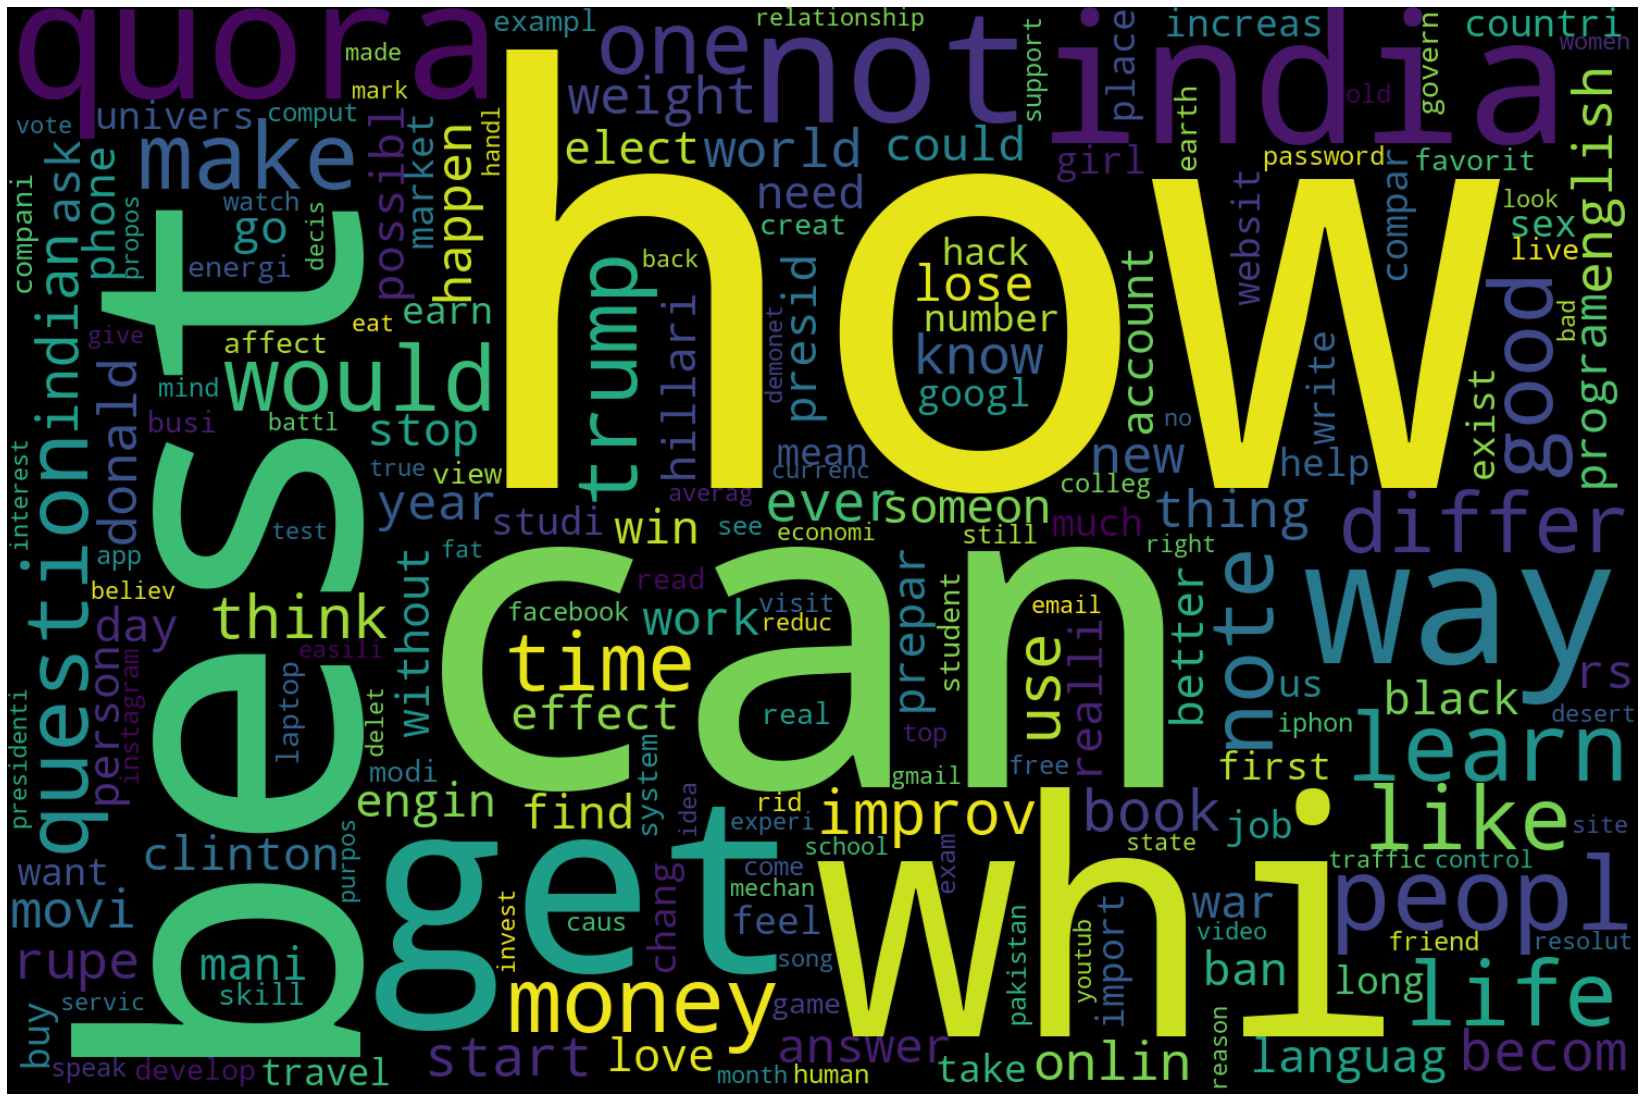

In [ ]:
worcloudPlot = WordCloud(background_color="black", width=1500, height=1000)
worcloudPlot.generate_from_frequencies(frequencies=freq_dict)
plt.figure(figsize=(30,20))
plt.imshow(worcloudPlot, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
#Non-duplicate questions only
freq_dict = dict()
for q1 in data_adv[data_adv['is_duplicate'] == 0]['question1']:
    for word in q1.split(" "):
        freq_dict[word] = freq_dict.get(word, 0) + 1
for q2 in data_adv[data_adv['is_duplicate'] == 0]['question2']:
    for word in q2.split(" "):
        freq_dict[word] = freq_dict.get(word, 0) + 1
feat_count_sorted = dict(sorted(freq_dict.items(), key = lambda x: x[1], reverse = True))
count_data = {"Words":list(feat_count_sorted.keys()), "Count": list(feat_count_sorted.values())}
count_df = pd.DataFrame(data = count_data)
count_df[:10]

,Words,Count
0,how,76526
1,can,41692
2,whi,29820
3,best,21181
4,not,18112
5,get,16254
6,use,12296
7,like,12008
8,good,10287
9,differ,10176


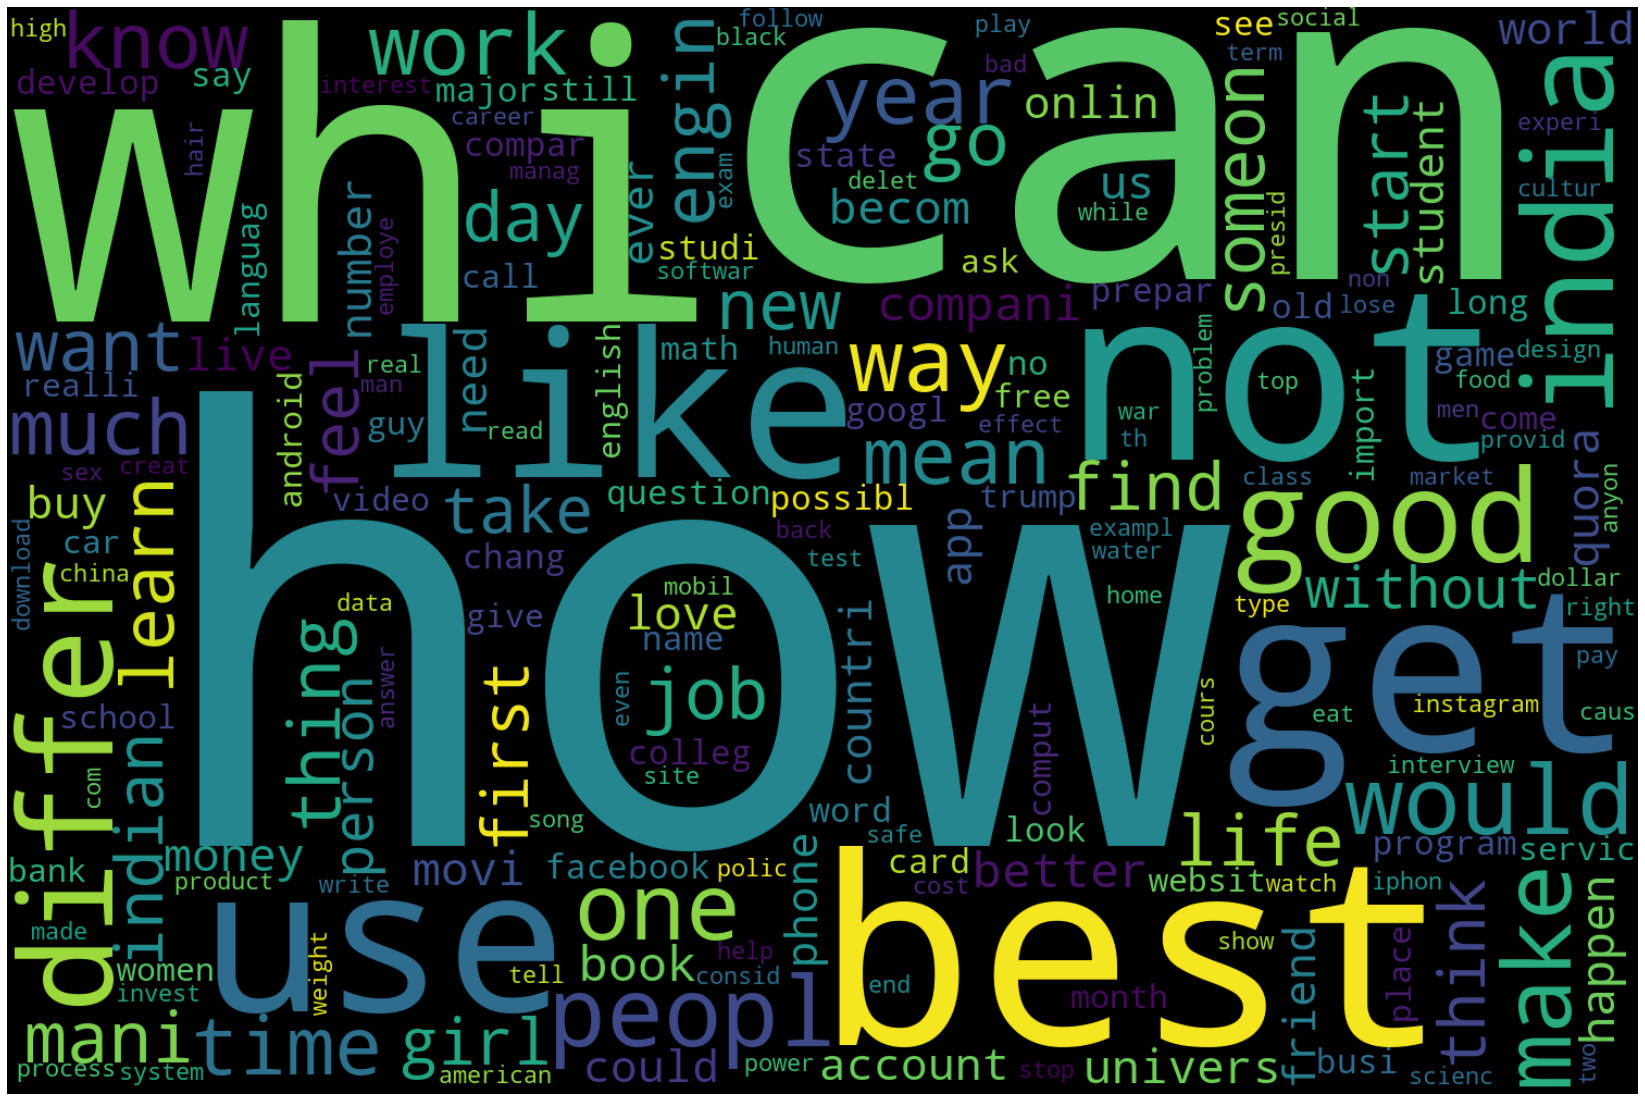

In [ ]:
worcloudPlot = WordCloud(background_color="black", width=1500, height=1000)
worcloudPlot.generate_from_frequencies(frequencies=freq_dict)
plt.figure(figsize=(30,20))
plt.imshow(worcloudPlot, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:

#saving new dataframe
data_adv.to_csv(os.path.join(DATAPATH, DATA_ADV2), index = False)

In [ ]:
data_adv2 = pd.read_csv(os.path.join(DATAPATH, DATA_ADV2))

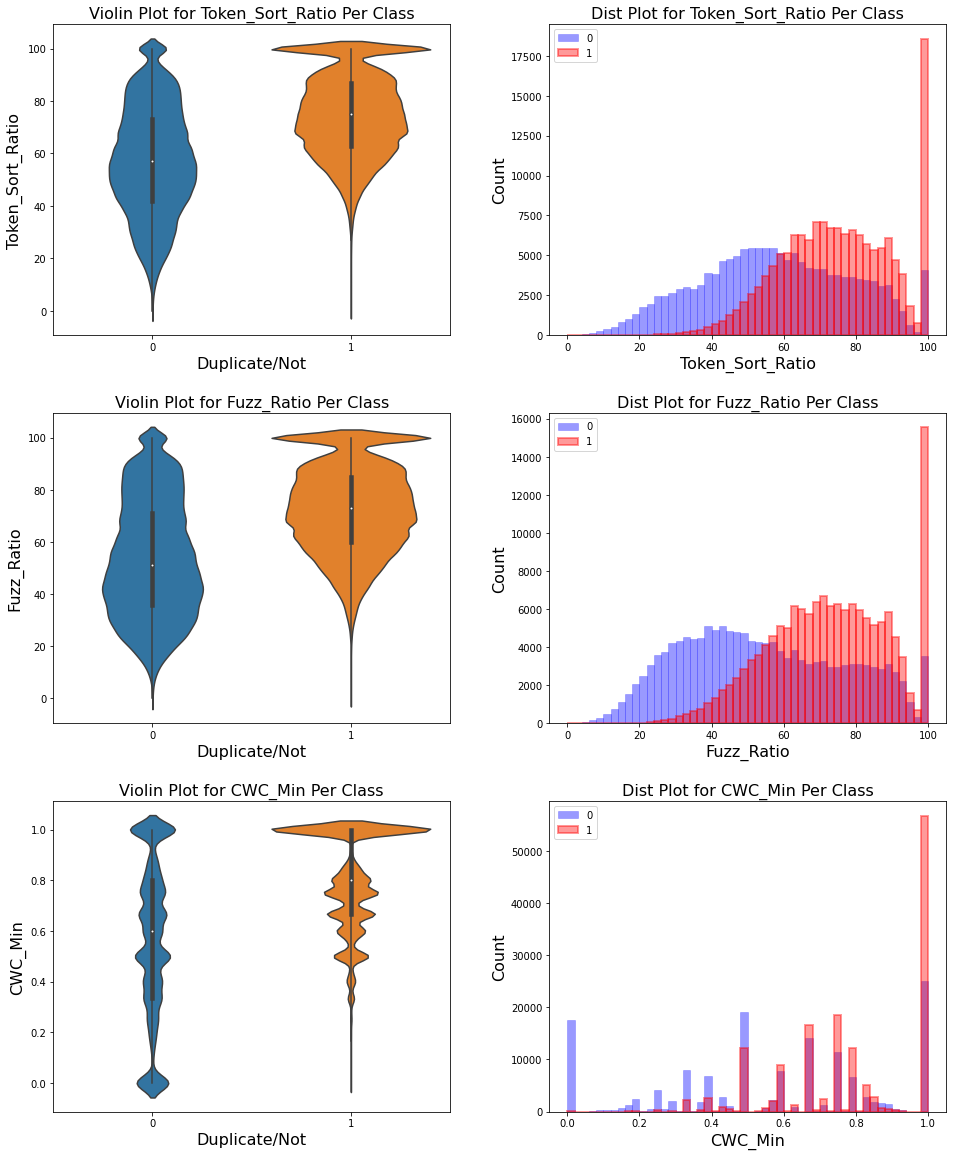

In [ ]:
plt.figure(figsize=(16, 20))

plt.subplot(3,2,1)
sns.violinplot(x = 'is_duplicate', y = 'Token_Sort_Ratio', data = data_adv2)
plt.title("Violin Plot for Token_Sort_Ratio Per Class", fontsize = 16)
plt.xlabel("Duplicate/Not", fontsize = 16)
plt.ylabel("Token_Sort_Ratio", fontsize = 16)

plt.subplot(3,2,2)
sns.distplot(data_adv2[data_adv2['is_duplicate'] == 0]['Token_Sort_Ratio'], kde = False, color = 'blue', label = '0', hist_kws=dict(edgecolor="b", linewidth=0.5))
sns.distplot(data_adv2[data_adv2['is_duplicate'] == 1]['Token_Sort_Ratio'], kde = False, color = 'red', label = '1', hist_kws=dict(edgecolor="r", linewidth=2))
plt.title("Dist Plot for Token_Sort_Ratio Per Class", fontsize = 16)
plt.xlabel("Token_Sort_Ratio", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.legend()

plt.subplot(3,2,3)
sns.violinplot(x = 'is_duplicate', y = 'Fuzz_Ratio', data = data_adv2)
plt.title("Violin Plot for Fuzz_Ratio Per Class", fontsize = 16)
plt.xlabel("Duplicate/Not", fontsize = 16)
plt.ylabel("Fuzz_Ratio", fontsize = 16)

plt.subplot(3,2,4)
sns.distplot(data_adv2[data_adv2['is_duplicate'] == 0]['Fuzz_Ratio'], kde = False, color = 'blue', label = '0', hist_kws=dict(edgecolor="b", linewidth=0.5))
sns.distplot(data_adv2[data_adv2['is_duplicate'] == 1]['Fuzz_Ratio'], kde = False, color = 'red', label = '1', hist_kws=dict(edgecolor="r", linewidth=2))
plt.title("Dist Plot for Fuzz_Ratio Per Class", fontsize = 16)
plt.xlabel("Fuzz_Ratio", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.legend()

plt.subplot(3,2,5)
sns.violinplot(x = 'is_duplicate', y = 'CWC_Min', data = data_adv2)
plt.title("Violin Plot for CWC_Min Per Class", fontsize = 16)
plt.xlabel("Duplicate/Not", fontsize = 16)
plt.ylabel("CWC_Min", fontsize = 16)

plt.subplot(3,2,6)
sns.distplot(data_adv2[data_adv2['is_duplicate'] == 0]['CWC_Min'], kde = False, color = 'blue', label = '0', hist_kws=dict(edgecolor="b", linewidth=0.5))
sns.distplot(data_adv2[data_adv2['is_duplicate'] == 1]['CWC_Min'], kde = False, color = 'red', label = '1', hist_kws=dict(edgecolor="r", linewidth=2))
plt.title("Dist Plot for CWC_Min Per Class", fontsize = 16)
plt.xlabel("CWC_Min", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.legend()

plt.subplots_adjust(hspace = 0.25, wspace = 0.25)
plt.show()

In [ ]:
data_adv2.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'Freq_qid1', 'Freq_qid2', 'Q1_len', 'Q2_len', 'Q1_n_words',
       'Q2_n_words', 'Word_Common', 'Word_Total', 'Word_Share',
       'Freq_q1+Freq_q2', 'Freq_q1-Freq_q2', 'CWC_Min', 'CWC_Max',
       'Last_Word_Equality', 'First_Word_Equality', 'Abs_Len_Diff', 'Mean_Len',
       'Fuzz_Ratio', 'Fuzz_Partial_Ratio', 'Token_Sort_Ratio',
       'Token_Set_Ratio', 'Longest_Substr_Ratio'],
      dtype='object')

In [ ]:
data_adv_sub = data_adv2[['is_duplicate','Freq_qid1', 'Freq_qid2', 'Q1_len', 'Q2_len', 'Q1_n_words',
       'Q2_n_words', 'Word_Common', 'Word_Total', 'Word_Share',
       'Freq_q1+Freq_q2', 'Freq_q1-Freq_q2', 'CWC_Min', 'CWC_Max',
       'Last_Word_Equality', 'First_Word_Equality', 'Abs_Len_Diff', 'Mean_Len',
       'Fuzz_Ratio', 'Fuzz_Partial_Ratio', 'Token_Sort_Ratio',
       'Token_Set_Ratio', 'Longest_Substr_Ratio']]
data_adv_sub = data_adv_sub.sample(5000)
data_adv_sub.shape

(5000, 23)

In [ ]:
data_adv_sub2 = data_adv_sub.drop('is_duplicate', axis = 1)
data_adv_sub2.shape

(5000, 22)

In [ ]:

data_adv_sub_standardized = StandardScaler().fit_transform(data_adv_sub2)
print(data_adv_sub_standardized.shape)
print(type(data_adv_sub_standardized))

(5000, 22)
<class 'numpy.ndarray'>


[t-SNE] Computing 4999 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 4.520s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.857585
[t-SNE] Computed conditional probabilities in 14.885s
[t-SNE] Iteration 50: error = 36.3787003, gradient norm = 0.0000000 (50 iterations in 18.000s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 36.378700
[t-SNE] Iteration 100: error = 0.2550042, gradient norm = 0.0021359 (50 iterations in 17.989s)
[t-SNE] Iteration 150: error = 0.1411870, gradient norm = 0.0002338 (50 iterations in 17.827s)
[t-SNE] Iteration 200: err

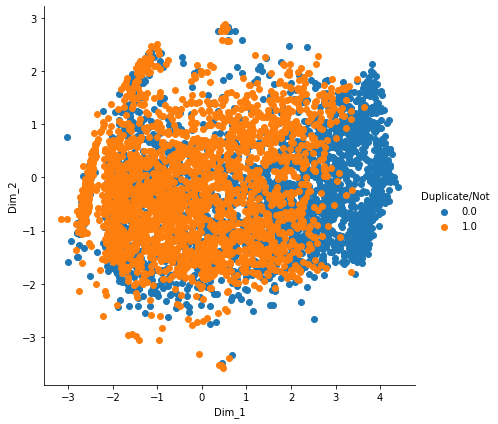

In [ ]:
model = TSNE(n_components=2, random_state=0, perplexity=2500, n_iter=600, verbose=2)

tsne_data = model.fit_transform(data_adv_sub_standardized)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, data_adv_sub['is_duplicate'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Duplicate/Not"))
sns.FacetGrid(tsne_df, hue="Duplicate/Not", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

Splitting into Train, CV and Test in 70%, 12% and 18% respectively.

In [ ]:
data_adv2 = pd.read_csv(os.path.join(DATAPATH, DATA_ADV2))
data_adv2.head()

,id,qid1,qid2,question1,question2,is_duplicate,Freq_qid1,Freq_qid2,Q1_len,Q2_len,Q1_n_words,Q2_n_words,Word_Common,Word_Total,Word_Share,Freq_q1+Freq_q2,Freq_q1-Freq_q2,CWC_Min,CWC_Max,Last_Word_Equality,First_Word_Equality,Abs_Len_Diff,Mean_Len,Fuzz_Ratio,Fuzz_Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio,Longest_Substr_Ratio
0,0,1,2,step step guid invest share market india,step step guid invest share market,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.999980,0.833319,0.0,1.0,1.0,6.5,92.0,100.0,92.0,100.0,0.849998
1,1,3,4,stori kohinoor koh noor diamond,would happen indian govern stole kohinoor koh ...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0,0.799984,0.399996,0.0,0.0,5.0,7.5,62.0,94.0,62.0,89.0,0.838707
2,2,5,6,how can increas speed internet connect while u...,how can internet speed increas hack dns,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.714276,0.555549,0.0,1.0,2.0,8.0,53.0,59.0,70.0,87.0,0.192307
3,3,7,8,whi mental lone how can solv,find remaind math math divid,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.0,0.0,1.0,5.5,25.0,30.0,18.0,20.0,0.071428
4,4,9,10,one dissolv water quik sugar salt methan carbo...,fish would surviv salt water,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0,0.399992,0.199998,0.0,0.0,5.0,7.5,24.0,50.0,43.0,53.0,0.109091


In [ ]:
X_Train, Test, Y_Train, TestLabels = train_test_split(data_adv2, data_adv2['is_duplicate'], stratify=data_adv2['is_duplicate'], test_size=0.18)
Train, CV, TrainLabels, CVLabels = train_test_split(X_Train, Y_Train, stratify=Y_Train, test_size=0.14634)

In [ ]:
print('Number of data points in train data:', Train.shape)
print('Train data labels shape:', TrainLabels.shape,'\n')

print('Number of data points in test data:', Test.shape)
print('Test data labels shape:', TestLabels.shape,'\n')

print('Number of data points in cross validation data:', CV.shape)
print('CV data labels shape:', CVLabels.shape,'\n')

Number of data points in train data: (208942, 28)
Train data labels shape: (208942,) 

Number of data points in test data: (53729, 28)
Test data labels shape: (53729,) 

Number of data points in cross validation data: (35819, 28)
CV data labels shape: (35819,) 



In [ ]:
print("----------Distribution of output variable in train data----------")
print("Class 0: {}%          Class 1: {}%:\n".format((TrainLabels.value_counts()[0]/(TrainLabels.value_counts()[0]+TrainLabels.value_counts()[1]))*100, (TrainLabels.value_counts()[1]/(TrainLabels.value_counts()[0]+TrainLabels.value_counts()[1]))*100))

print("----------Distribution of output variable in test data----------")
print("Class 0: {}%          Class 1: {}%:\n".format((TestLabels.value_counts()[0]/(TestLabels.value_counts()[0]+TestLabels.value_counts()[1]))*100, (TestLabels.value_counts()[1]/(TestLabels.value_counts()[0]+TestLabels.value_counts()[1]))*100))

print("----------Distribution of output variable in CV data----------")
print("Class 0: {}%          Class 1: {}%:".format((CVLabels.value_counts()[0]/(CVLabels.value_counts()[0]+CVLabels.value_counts()[1]))*100, (CVLabels.value_counts()[1]/(CVLabels.value_counts()[0]+CVLabels.value_counts()[1]))*100))

----------Distribution of output variable in train data----------
Class 0: 49.98468474504886%          Class 1: 50.01531525495113%:

----------Distribution of output variable in test data----------
Class 0: 49.98417986562192%          Class 1: 50.01582013437809%:

----------Distribution of output variable in CV data----------
Class 0: 49.984645020799015%          Class 1: 50.015354979200985%:


Featurizing Question1 and Question2 by W2V

In [ ]:
def listOfListSent(TrainText):
    listOfSentences = []
    for sentence in TrainText.values:
        subSentence = []
        for word in sentence.split():
            subSentence.append(word)  
        listOfSentences.append(subSentence)
    return listOfSentences

In [ ]:
# first create w2v feature only for question1 in the order train of question1 then cv of question1 then test of question1
# second create w2v feature only for question2 in the order train of question2 then cv of question2 then test of question2

def create_w2v(df, which_df, which_ques):
    listOfSentences = listOfListSent(df[which_ques])
    if which_df == "Train":
        # compute average word2vec for each text in train data.
        w2vModel = gensim.models.Word2Vec(listOfSentences, size=300, min_count=5, workers=4)
        pickle.dump(w2vModel, open(os.path.join(DATAPATH, "w2vModel.sav"), 'wb'))
        train_text_feature_w2v = []
        for sentence in listOfSentences:
            sentenceVector = np.zeros(300)
            TotalWordsPerSentence = 0
            for word in sentence:
                try:
                    vect = w2vModel.wv[word]
                    sentenceVector += vect
                    TotalWordsPerSentence += 1
                except:
                    pass
            if TotalWordsPerSentence!= 0:
                sentenceVector /= TotalWordsPerSentence
            train_text_feature_w2v.append(sentenceVector)
        return train_text_feature_w2v
    else:
        # compute average word2vec for each text in cv and test data.
        w2vModelLoaded = pickle.load(open(os.path.join(DATAPATH, "w2vModel.sav"), 'rb'))
        cv_test_text_feature_w2v = []
        for sentence in listOfSentences:
            sentenceVector = np.zeros(300)
            TotalWordsPerSentence = 0
            for word in sentence:
                try:
                    vect = w2vModelLoaded.wv[word]
                    sentenceVector += vect
                    TotalWordsPerSentence += 1
                except:
                    pass
            if TotalWordsPerSentence!= 0:
                sentenceVector /= TotalWordsPerSentence
            cv_test_text_feature_w2v.append(sentenceVector)
        return cv_test_text_feature_w2v
        

In [ ]:
w2vFeaturesTrainQuestion1 = create_w2v(Train, "Train", "question1")
w2vFeaturesCVQuestion1 = create_w2v(CV, "CV", "question1")
w2vFeaturesTestQuestion1 = create_w2v(Test, "Test", "question1")

w2vFeaturesTrainQuestion2 = create_w2v(Train, "Train", "question2")
w2vFeaturesCVQuestion2 = create_w2v(CV, "CV", "question2")
w2vFeaturesTestQuestion2 = create_w2v(Test, "Test", "question2")

print("Shape of w2vFeaturesTrainQuestion1 = {}".format(np.array(w2vFeaturesTrainQuestion1).shape))
print("Shape of w2vFeaturesCVQuestion1 = {}".format(np.array(w2vFeaturesCVQuestion1).shape))
print("Shape of w2vFeaturesTestQuestion1 = {}\n".format(np.array(w2vFeaturesTestQuestion1).shape))

print("Shape of w2vFeaturesTrainQuestion2 = {}".format(np.array(w2vFeaturesTrainQuestion2).shape))
print("Shape of w2vFeaturesCVQuestion2 = {}".format(np.array(w2vFeaturesCVQuestion2).shape))
print("Shape of w2vFeaturesTestQuestion2 = {}".format(np.array(w2vFeaturesTestQuestion2).shape))

Shape of w2vFeaturesTrainQuestion1 = (208942, 300)
Shape of w2vFeaturesCVQuestion1 = (35819, 300)
Shape of w2vFeaturesTestQuestion1 = (53729, 300)

Shape of w2vFeaturesTrainQuestion2 = (208942, 300)
Shape of w2vFeaturesCVQuestion2 = (35819, 300)
Shape of w2vFeaturesTestQuestion2 = (53729, 300)


In [ ]:

Train_New = Train.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis = 1, inplace = False)
CV_New = CV.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis = 1, inplace = False)
Test_New = Test.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis = 1, inplace = False)

#-----------------------------Stacking Train Data and Saving it-----------------------------#
TrainFinal = np.hstack((Train_New.values, np.array(w2vFeaturesTrainQuestion1), np.array(w2vFeaturesTrainQuestion2)))
TrainFinalLabels = TrainLabels
print("Shape of Train Data = {}".format(TrainFinal.shape))
print("Shape of Train Labels = {}\n".format(TrainFinalLabels.shape))
pickle.dump(TrainFinal, open(os.path.join(DATAPATH, 'TrainFinal.sav'), 'wb'))
pickle.dump(TrainFinalLabels, open(os.path.join(DATAPATH, 'TrainFinalLabels.sav'), 'wb'))

#-----------------------------Stacking CV Data and Saving it-----------------------------#
CVFinal = np.hstack((CV_New.values, np.array(w2vFeaturesCVQuestion1), np.array(w2vFeaturesCVQuestion2)))
CVFinalLabels = CVLabels
print("Shape of CV Data = {}".format(CVFinal.shape))
print("Shape of CV Labels = {}\n".format(CVFinalLabels.shape))
pickle.dump(CVFinal, open(os.path.join(DATAPATH, 'CVFinal.sav'), 'wb'))
pickle.dump(CVFinalLabels, open(os.path.join(DATAPATH, 'CVFinalLabels.sav'), 'wb'))

#-----------------------------Stacking Test Data and Saving it-----------------------------#
TestFinal = np.hstack((Test_New.values, np.array(w2vFeaturesTestQuestion1), np.array(w2vFeaturesTestQuestion2)))
TestFinalLabels = TestLabels
print("Shape of Test Data = {}".format(TestFinal.shape))
print("Shape of Test Labels = {}\n".format(TestFinalLabels.shape))
pickle.dump(TestFinal, open(os.path.join(DATAPATH, 'TestFinal.sav'), 'wb'))
pickle.dump(TestFinalLabels, open(os.path.join(DATAPATH, 'TestFinalLabels.sav'), 'wb'))

Shape of Train Data = (208942, 622)
Shape of Train Labels = (208942,)

Shape of CV Data = (35819, 622)
Shape of CV Labels = (35819,)

Shape of Test Data = (53729, 622)
Shape of Test Labels = (53729,)



In [ ]:
TrainFinal = pickle.load(open(os.path.join(DATAPATH, "TrainFinal.sav"), 'rb'))
TrainFinalLabels = np.array(pickle.load(open(os.path.join(DATAPATH, "TrainFinalLabels.sav"), 'rb')))
CVFinal = pickle.load(open(os.path.join(DATAPATH, "CVFinal.sav"), 'rb'))
CVFinalLabels = np.array(pickle.load(open(os.path.join(DATAPATH, "CVFinalLabels.sav"), 'rb')))
TestFinal = pickle.load(open(os.path.join(DATAPATH, "TestFinal.sav"), 'rb'))
TestFinalLabels = np.array(pickle.load(open(os.path.join(DATAPATH, "TestFinalLabels.sav"), 'rb')))

print("Shape of Train Data = {}".format(TrainFinal.shape))
print("Shape of Train Labels = {}\n".format(TrainFinalLabels.shape))
print("Shape of CV Data = {}".format(CVFinal.shape))
print("Shape of CV Labels = {}\n".format(CVFinalLabels.shape))
print("Shape of Test Data = {}".format(TestFinal.shape))
print("Shape of Test Labels = {}\n".format(TestFinalLabels.shape))

Shape of Train Data = (208942, 622)
Shape of Train Labels = (208942,)

Shape of CV Data = (35819, 622)
Shape of CV Labels = (35819,)

Shape of Test Data = (53729, 622)
Shape of Test Labels = (53729,)



In [ ]:
# Plotting function for confusion matrix, precision matrix and recall matrix

def print_confusionMatrix(Y_TestLabels, PredictedLabels):
    confusionMatx = confusion_matrix(Y_TestLabels, PredictedLabels)
    
    precision = confusionMatx/confusionMatx.sum(axis = 0)
    
    recall = (confusionMatx.T/confusionMatx.sum(axis = 1)).T
    
    # confusionMatx = [[1, 2],
    #                  [3, 4]]
    # confusionMatx.T = [[1, 3],
    #                   [2, 4]]
    # confusionMatx.sum(axis = 1)  axis=0 corresponds to columns and axis=1 corresponds to rows in two diamensional array
    # confusionMatx.sum(axix =1) = [[3, 7]]
    # (confusionMatx.T)/(confusionMatx.sum(axis=1)) = [[1/3, 3/7]
    #                                                  [2/3, 4/7]]

    # (confusionMatx.T)/(confusionMatx.sum(axis=1)).T = [[1/3, 2/3]
    #                                                    [3/7, 4/7]]
    # sum of row elements = 1
    plt.figure(figsize=(25, 7))
    labels = [0, 1]
    
    plt.subplot(1, 3, 1)
    sns.heatmap(confusionMatx, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title("Confusion Matrix", fontsize = 20)
    plt.xlabel('Predicted Class', fontsize = 18)
    plt.ylabel('Original Class', fontsize = 18)
    plt.tick_params(labelsize = 18)
    
    plt.subplot(1, 3, 2)
    sns.heatmap(precision, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title("Precision Matrix", fontsize = 20)
    plt.xlabel('Predicted Class', fontsize = 18)
    plt.ylabel('Original Class', fontsize = 18)
    plt.tick_params(labelsize = 18)

    plt.subplot(1, 3, 3)
    sns.heatmap(recall, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title("Recall Matrix", fontsize = 20)
    plt.xlabel('Predicted Class', fontsize = 18)
    plt.ylabel('Original Class', fontsize = 18)
    plt.tick_params(labelsize = 18)
    
    plt.subplots_adjust(wspace = 0.25)
    plt.show()

Log loss on Test Data using Random Model 0.8845462092543904


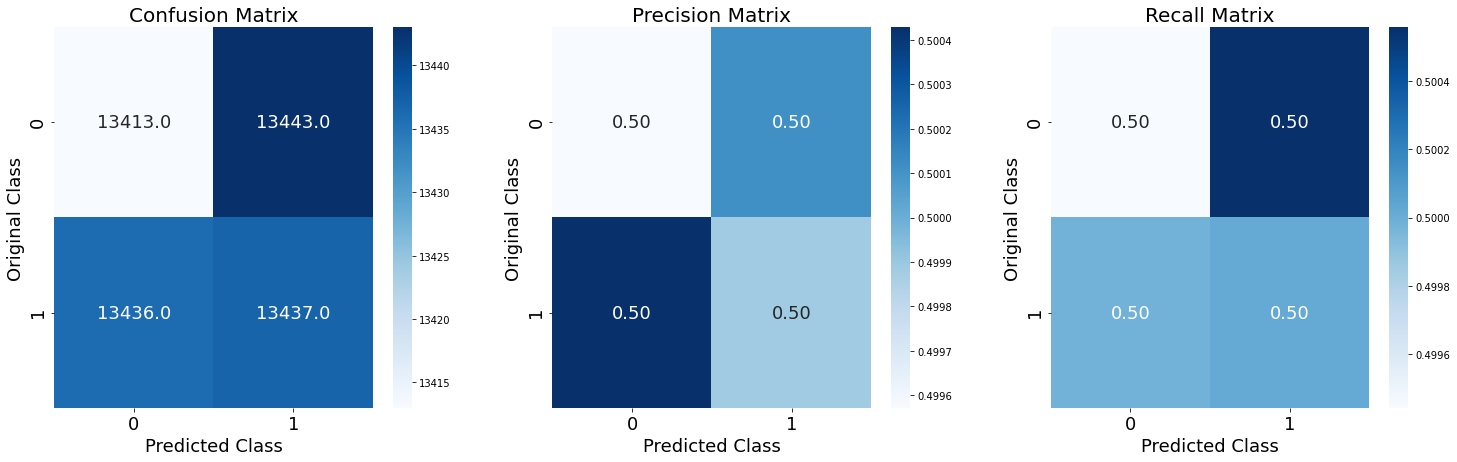

In [ ]:
# we need to generate 2 numbers and the sum of numbers should be 1
# one solution is to genarate 2 numbers and divide each of the numbers by their sum
predicted = np.zeros((TestFinal.shape[0],2))
for i in range(TestFinal.shape[0]):
    rand_num = np.random.rand(1,2)
    predicted[i] = rand_num/sum(rand_num[0])
print("Log loss on Test Data using Random Model",log_loss(TestFinalLabels, predicted))
print_confusionMatrix(TestFinalLabels, np.argmax(predicted, axis = 1))

In [ ]:
Log_Loss = []
Accuracy_Scores = []

Logistic Regression

For alpha value of 1e-05 CV log loss = 0.5098377589107982
For alpha value of 0.0001 CV log loss = 0.4934021751513402
For alpha value of 0.001 CV log loss = 0.4902264518592265
For alpha value of 0.01 CV log loss = 0.49327350915103985
For alpha value of 0.1 CV log loss = 0.5020697597855018
For alpha value of 1 CV log loss = 0.518084252639591
For alpha value of 10 CV log loss = 0.5519877495098228
For alpha value of 100 CV log loss = 0.5776806772464608


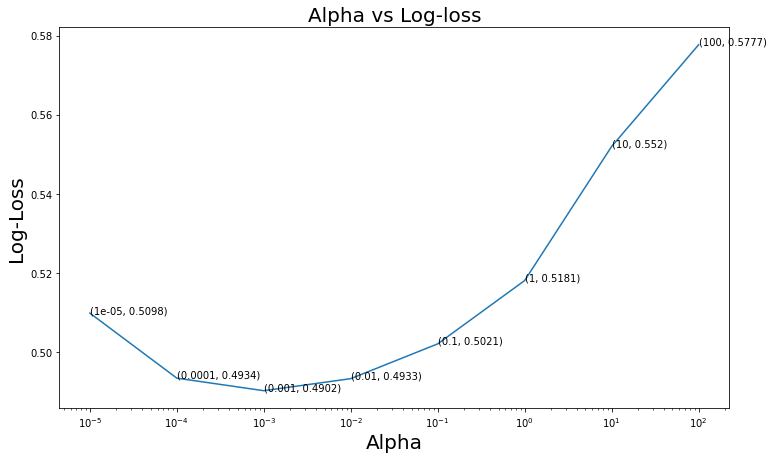

In [ ]:
Scalar = StandardScaler()
Scalar.fit(TrainFinal)
TrainFinalStd = Scalar.transform(TrainFinal)
CVFinalStd = Scalar.transform(CVFinal)
TestFinalStd = Scalar.transform(TestFinal)

alpha = [10**x for x in range(-5, 3)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(loss = "log", alpha = i)
    clf.fit(TrainFinalStd, TrainFinalLabels)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf.fit(TrainFinalStd, TrainFinalLabels)
    predicted_y = calib_clf.predict_proba(CVFinalStd)
    cv_log_loss.append(log_loss(CVFinalLabels, predicted_y))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(CVFinalLabels, predicted_y)))

plt.figure(figsize = (12, 7))
plt.xscale('log')
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

For values of best alpha = 0.001, Test LogLoss = 0.4929607825699191, Test Accuracy Score = 75.68%


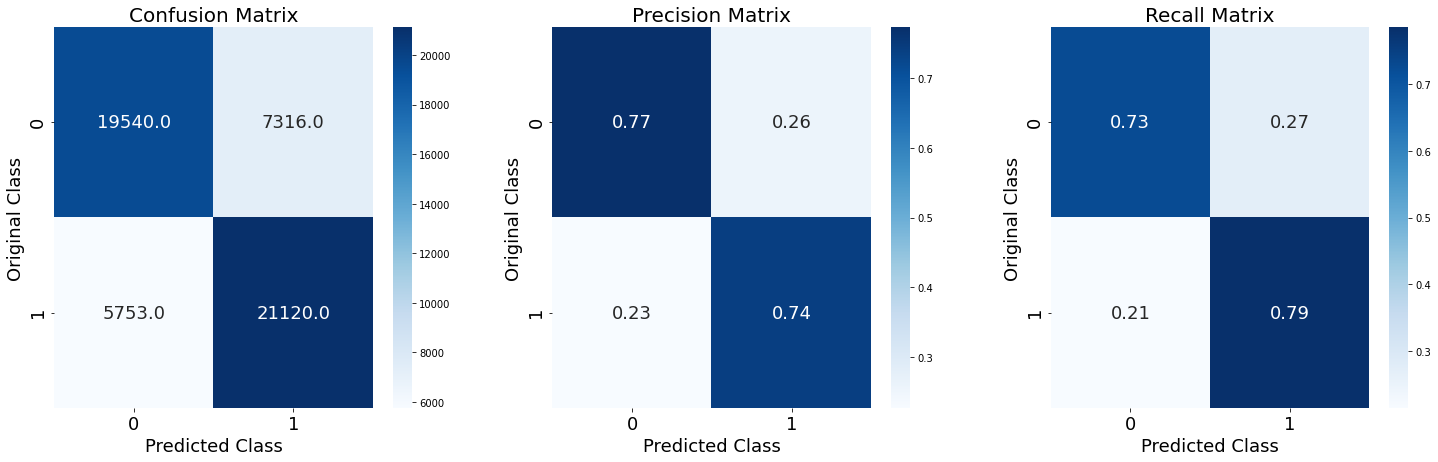

In [ ]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(loss = "log", alpha = best_alpha)
clf.fit(TrainFinalStd, TrainFinalLabels)
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(TrainFinalStd, TrainFinalLabels)

predict_test = calib_clf.predict_proba(TestFinalStd)
LR_LogLoss = log_loss(TestFinalLabels, predict_test)
LR_Accuracy = accuracy_score(TestFinalLabels, calib_clf.predict(TestFinalStd))
print('For values of best alpha = {}, Test LogLoss = {}, Test Accuracy Score = {}%'.format(best_alpha, LR_LogLoss, round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestFinalLabels, calib_clf.predict(TestFinalStd))

Log_Loss.append(LR_LogLoss)
Accuracy_Scores.append(LR_Accuracy)

SUPPORT VECTOR MACHINE

For alpha value of 1e-05 CV log loss = 0.5129856565195368
For alpha value of 0.0001 CV log loss = 0.49294917775136665
For alpha value of 0.001 CV log loss = 0.4908383415332393
For alpha value of 0.01 CV log loss = 0.4929000851092075
For alpha value of 0.1 CV log loss = 0.49961751438001506
For alpha value of 1 CV log loss = 0.5132187515228599
For alpha value of 10 CV log loss = 0.5546714264548903
For alpha value of 100 CV log loss = 0.5826856289108732


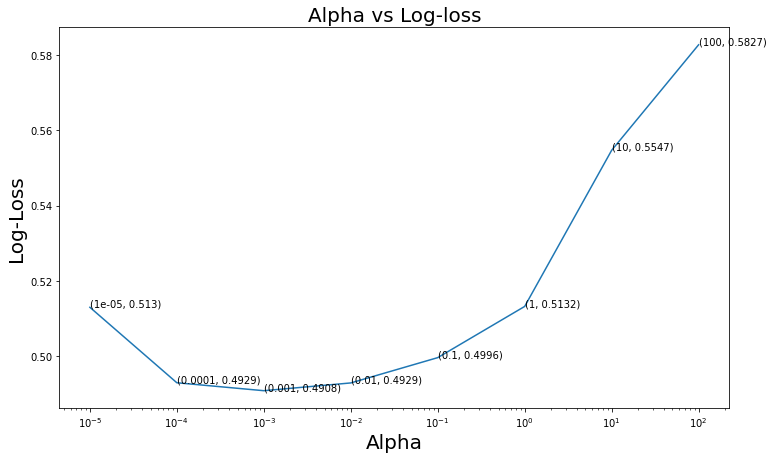

In [ ]:
alpha = [10**x for x in range(-5, 3)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(loss = "hinge", alpha = i)
    clf.fit(TrainFinalStd, TrainFinalLabels)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf.fit(TrainFinalStd, TrainFinalLabels)
    predicted_y = calib_clf.predict_proba(CVFinalStd)
    cv_log_loss.append(log_loss(CVFinalLabels, predicted_y))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(CVFinalLabels, predicted_y)))

plt.figure(figsize = (12, 7))
plt.xscale('log')
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

For values of best alpha = 0.001, Test LogLoss = 0.4949643908256295, Test Accuracy Score = 75.83%


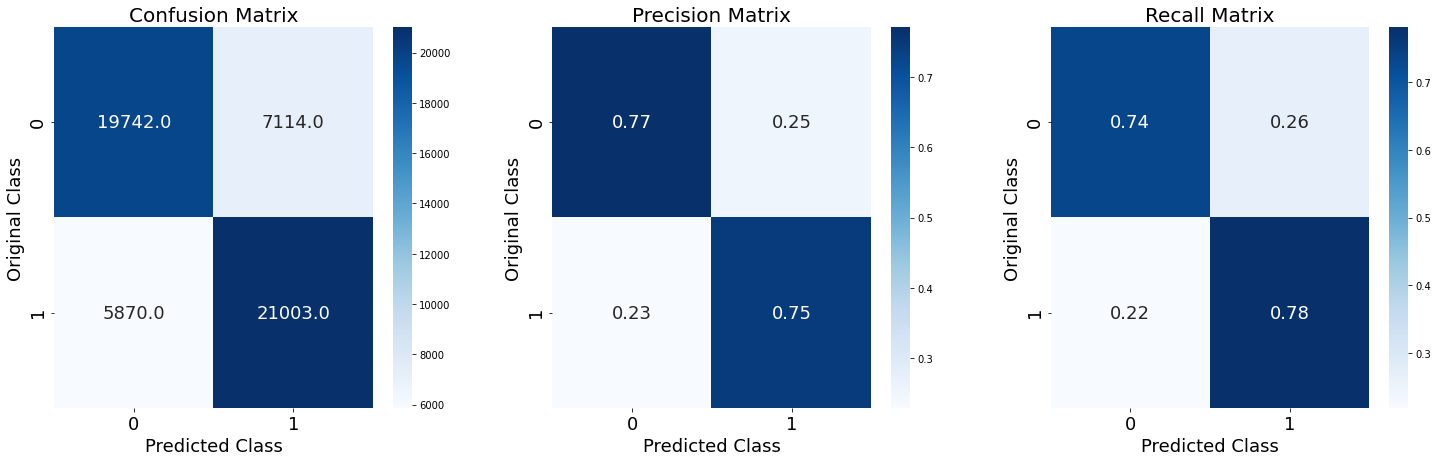

In [ ]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(loss = "hinge", alpha = best_alpha)
clf.fit(TrainFinalStd, TrainFinalLabels)
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(TrainFinalStd, TrainFinalLabels)

predict_test = calib_clf.predict_proba(TestFinalStd)
LR_LogLoss = log_loss(TestFinalLabels, predict_test)
LR_Accuracy = accuracy_score(TestFinalLabels, calib_clf.predict(TestFinalStd))
print('For values of best alpha = {}, Test LogLoss = {}, Test Accuracy Score = {}%'.format(best_alpha, LR_LogLoss, round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestFinalLabels, calib_clf.predict(TestFinalStd))

Log_Loss.append(LR_LogLoss)
Accuracy_Scores.append(LR_Accuracy)

XG Boost

In [ ]:
#https://xgboost.readthedocs.io/en/latest/python/python_intro.html
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(TrainFinal, label=TrainFinalLabels)
d_test = xgb.DMatrix(CVFinal, label=CVFinalLabels)

watchlist = [(d_train, 'train'), (d_test, 'valid')]
bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

[0]	train-logloss:0.687177	valid-logloss:0.687276
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.638426	valid-logloss:0.638477
[20]	train-logloss:0.602689	valid-logloss:0.60279
[30]	train-logloss:0.575606	valid-logloss:0.575938
[40]	train-logloss:0.554889	valid-logloss:0.555192
[50]	train-logloss:0.538248	valid-logloss:0.538714
[60]	train-logloss:0.52496	valid-logloss:0.525512
[70]	train-logloss:0.514274	valid-logloss:0.515007
[80]	train-logloss:0.505174	valid-logloss:0.506107
[90]	train-logloss:0.497467	valid-logloss:0.498481
[100]	train-logloss:0.490948	valid-logloss:0.492056
[110]	train-logloss:0.485168	valid-logloss:0.486306
[120]	train-logloss:0.480063	valid-logloss:0.481315
[130]	train-logloss:0.475606	valid-logloss:0.476976
[140]	train-logloss:0.47188	valid-logloss:0.473381
[150]	train-logloss:0.468431	valid-logloss:0.469938
[160]	train-logloss:0.465057	va

Test LogLoss = 0.435296369783249, Test Accuracy Score = 79.04%


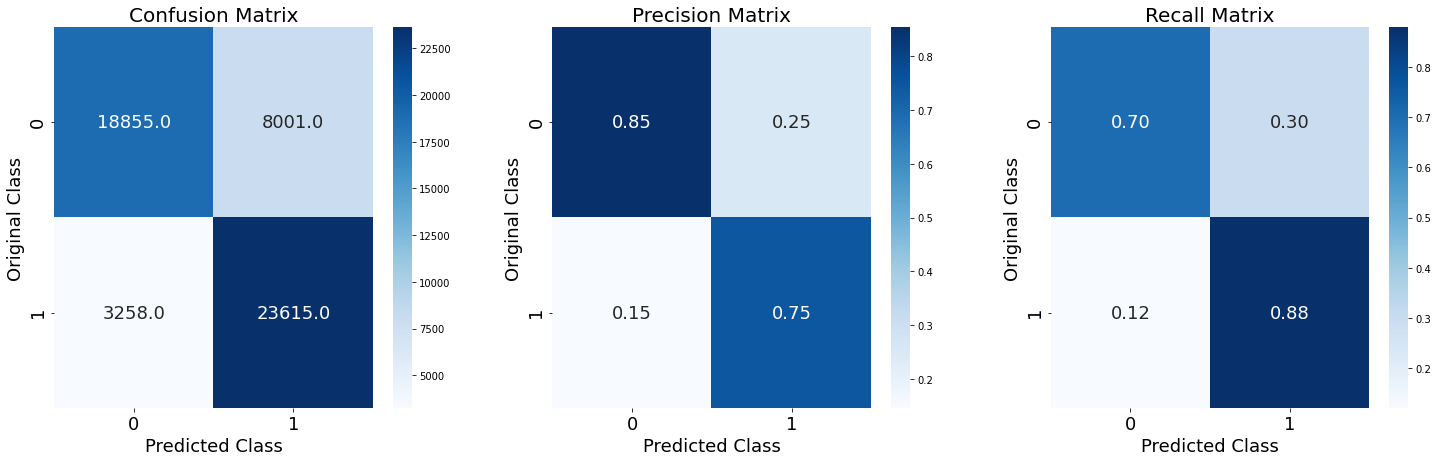

In [ ]:
d_test = xgb.DMatrix(TestFinal)
LR_LogLoss = log_loss(TestFinalLabels, bst.predict(d_test))
LR_Accuracy = accuracy_score(TestFinalLabels, list(map(lambda x: int(x>0.5), bst.predict(d_test))))
print('Test LogLoss = {}, Test Accuracy Score = {}%'.format(LR_LogLoss, round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestFinalLabels,  list(map(lambda x: int(x>0.5), bst.predict(d_test))))

Log_Loss.append(LR_LogLoss)
Accuracy_Scores.append(LR_Accuracy)

In [ ]:
df = pd.DataFrame({
    'Model': ["Logistic Regression", "SVC", "XGBoost"], 
    'Accuracy': Accuracy_Scores,
    'Log-Loss': Log_Loss
})
df

,Model,Accuracy,Log-Loss
0,Logistic Regression,0.756761,0.492961
1,SVC,0.758343,0.494964
2,XGBoost,0.790448,0.435296


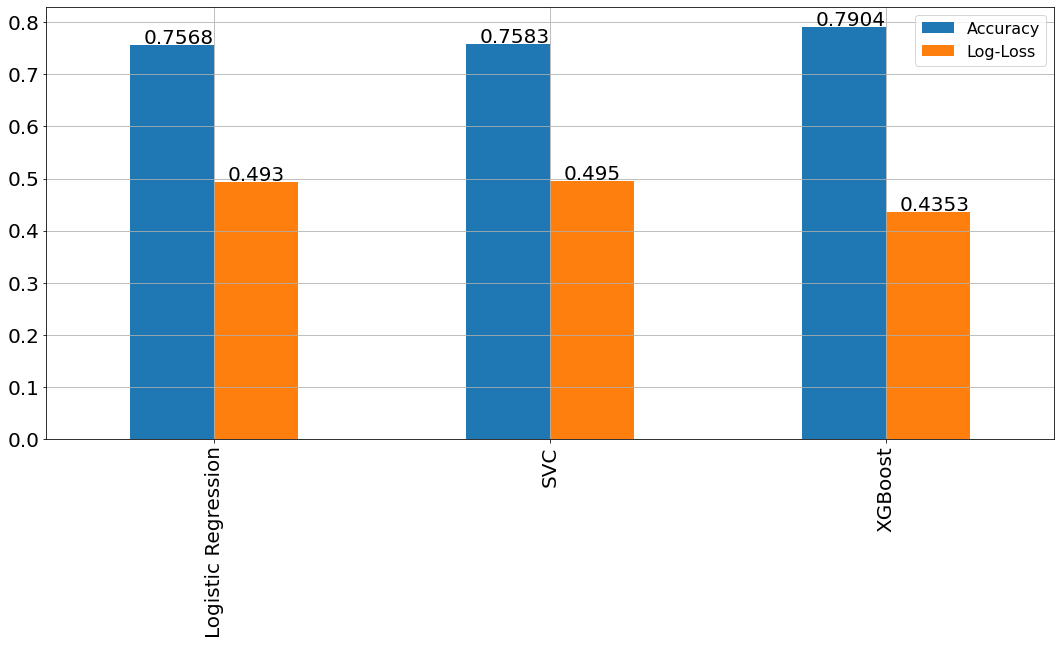

In [ ]:
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,1,1])
df.plot(x = 'Model', y = ['Accuracy', 'Log-Loss'], figsize = (14, 6), kind = 'bar', ax = axes, grid = True)
plt.legend(fontsize = 16)
axes.set_xlabel("")
axes.tick_params(labelsize = 20)
for i in axes.patches:
    axes.text(i.get_x()+0.04, i.get_height()+0.003, str(round(i.get_height(), 4)), fontsize=20, color='black')
plt.show()